In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium
import folium.plugins
from folium import Figure
from folium.plugins import HeatMapWithTime
from datetime import datetime, timedelta

# For real distance
import osmnx as ox
import networkx as nx

import src.cleaning as cleaning
import src.visualizations as vis
import src.your_trip as trip

In [5]:
# Sample to test functions:
apr_14 = pd.read_csv('../../../Desktop/final_project_data/2014/2014-04 - Citi Bike trip data.csv')

# 1. CLEANING PROCESS

# Rename columns

In [6]:
apr_14 = cleaning.rename_columns(apr_14)

#  Straight line Distance

In [7]:
apr_14 = cleaning.trip_distance(apr_14)

# Hour: start_hour & end_hour (same function, 2 columns)

- Integer value for the hour, e.g. 12, 18.

In [8]:
apr_14 = cleaning.get_hour (apr_14)

# Date: trip_date
- time series date format for date, including year, month and day, and excluding hour, minute and second.

In [9]:
apr_14 = cleaning.get_date (apr_14)

# Formatting: started_at and ended_at in datetime format

In [10]:
apr_14 = cleaning.datetime_format (apr_14)

#  Month, weekday, weekend

In [11]:
apr_14 = cleaning.get_categorical_date (apr_14)

# Cleaned and enriched dataframe to CSV

In [12]:
apr_14.to_csv('data/april_2014.csv', index=False)

In [13]:
april_14 = pd.read_csv('data/april_2014.csv')

# Open Street Map: real_distance
### Function to create subdataframes and save them as csv.

In [14]:
# in Collab

# cleaning.dataframe_split (df, n): Splits the dataframe in n subdataframes to make it more processable.
# cleaning.get_real_distance (df): uses osmnx and networkx to compute the shortest available path distance.

# rideable_type

In [15]:
# Infer from 2022 datasets.

# trip_cost ()

¡You need to get bike type before!

- float $ value in function of rideable_type, duration and member_casual.

Subscriber
- Classic.
If trip_duration < 45*60, cost = 0
Elif trip_duration > 45*60, cost = (trip_duration - 45 * 60) / 60 * 0.17

- Electric
If trip_duration =< 45*60: cost = trip_duration / 60 * 0.17, limit 3.
If trip_duration > 45*60: cost = 3 + (trip_duration - 45 * 60) / 60 * 0.17

Casual
- Single trip 
    - Casual & - Electric
    If trip_duration <= 30*60 -> 4.49
    Elif trip_duration > 30 * 60 -> 4.49 + (trip_duration - 30 * 60) / 60 * 0.26

- Day Pass
    - Casual 
    - Electric

In [16]:
# need to know rideable type.

# Station non-bike trips balance

## Bike Route (not by human usage):

All bikes journey function includes bike route function.

In [17]:
all_bikes_journey_list = cleaning.all_bikes_journey (april_14)

## Non user trip mobility dictionary and information:

### Three functions that enrich a dictionary containing all info regarding mobility from one station to another through trucks.

In [18]:
stations_transfers_dictionary = cleaning.non_trip_mobility_dict (apr_14)
stations_transfers_dictionary = cleaning.transportations (stations_transfers_dictionary, all_bikes_journey_list)
stations_transfers_dictionary = cleaning.station_balance (stations_transfers_dictionary)

# Truck trips

Record all bike movements not attributable to user trips.
- Bike ID
- Date range
- Transported from
- Transported to

Sort by date, group by station.

### All transfers use single bike truck transfers function:

In [20]:
total_transfers = cleaning.all_transfers (april_14)

In [23]:
total_transfers = cleaning.datetime_format_trucks (total_transfers)

In [27]:
total_transfers.to_csv('data/truck_transfers.csv', index=False)

# 2. Visualizations

In [30]:
# Functions defined in source folder, deployed in streamlit app.

In [1]:
# Hourly distribution by day:
def hourly_dist (df, day):
    test_map_viz = df[['start_hour', 'started_at', 'bike_id', 'start_lat', 'start_lng', 'weekday']]
    test_map_viz = test_map_viz[test_map_viz['weekday'] == day]

    lat_lng_list = []
    for i in range(24):
        temp=[]
        for index, row in test_map_viz[test_map_viz['start_hour'] == i].iterrows():
            temp.append([row['start_lat'],row['start_lng']])
        lat_lng_list.append(temp)

    figure1 = Figure(width=850,height=550)
    new_york1 = folium.Map(location=[40.712776, -74.005974],zoom_start=12)

    figure1.add_child(new_york1)
    folium.TileLayer('cartodbpositron').add_to(new_york1)
    gradient = {.33: 'white', .66: 'lightblue', 1: 'blue'}

    HeatMapWithTime(lat_lng_list, radius=5, auto_play=True, position='bottomright', gradient=gradient).add_to(new_york1)

    return figure1

In [ ]:
hourly_dist (april_14, 'Monday')

# 3. Your Trip

In [2]:
trucks = pd.read_csv('data/truck_transfers.csv')
april = pd.read_csv('data/april_2014.csv')

In [3]:
ALL_TRIPS = cleaning.concat_all_bike_trips (april)

/Users/gerardrius/Ironhack/projects/Final/src/cleaning.py:452: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  result_df = pd.DataFrame({'last_end': last_end, 'ended_at': etime, 'next_start': next_start, 'started_at': stime})


In [4]:
ALL_TRIPS.to_csv('data/all_trips.csv', index = False)

In [3]:
ALL_TRIPS = pd.read_csv('data/all_trips.csv')

In [4]:
capacity_dict = cleaning.capacity_dictionary (ALL_TRIPS)

In [5]:
# But this is an approx, precise in a daily scale.
# capacity_dict

In [6]:
station_ = trip.station_load_time_series (ALL_TRIPS, id)
bike_availability = station_[0]['bikes_in_station'].to_list()
time_range = trip.time_range
time_series_df = pd.DataFrame({'time': time_range[:-1], 'bikes_available': bike_availability[:-1]})
time_series_df['time'] = pd.to_datetime(time_series_df['time'], infer_datetime_format = True)
time_series_df['docks_available'] = [station_[1]]*time_series_df.shape[0] - time_series_df['bikes_available']

model = Prophet()

data = time_series_df[['time', 'bikes_available']]
data = data.rename(columns = {'time': 'ds', 'bikes_available': 'y'})

model.fit(data)

future = model.make_future_dataframe(periods=96, freq='15min')

forecast = model.predict(future)

predictions = forecast['yhat'].tail(96).values
clean_predictions = []
for prediction in predictions:
    clean_predictions.append(round(prediction))

clean_predictions[]

In [68]:
station_519[0]

,ends,starts,bikes_in_station
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
2876,8712.0,8712.0,0.0
2877,8712.0,8712.0,0.0
2878,8712.0,8712.0,0.0
2879,8712.0,8712.0,0.0


In [63]:
round(station_519[0].iloc[1224]['bikes_in_station']/station_519[1]*100, 2)

37.14

In [7]:
bike_availability = station_519[0]['bikes_in_station'].to_list()
time_range = trip.time_range

In [8]:
time_series_df = pd.DataFrame({'time': time_range[:-1], 'bikes_available': bike_availability[:-1]})
time_series_df['time'] = pd.to_datetime(time_series_df['time'], infer_datetime_format = True)
time_series_df['docks_available'] = [station_519[1]]*time_series_df.shape[0] - time_series_df['bikes_available']

time_series_df

,time,bikes_available,docks_available
0,2014-04-01 00:00:00,0.0,70.0
1,2014-04-01 00:15:00,0.0,70.0
2,2014-04-01 00:30:00,0.0,70.0
3,2014-04-01 00:45:00,0.0,70.0
4,2014-04-01 01:00:00,0.0,70.0
...,...,...,...
2875,2014-04-30 22:45:00,0.0,70.0
2876,2014-04-30 23:00:00,0.0,70.0
2877,2014-04-30 23:15:00,0.0,70.0
2878,2014-04-30 23:30:00,0.0,70.0


In [9]:
fig = px.area(time_series_df, 
        x='time',
        y= 'bikes_available',
        labels={'time': 'Time', 'bikes_available': 'Number of Bikes parked in Station'},
        color_discrete_sequence =['darkblue']*len(time_series_df),
        title = 'Bike Availability in Station ID')
fig.show()

In [10]:
import plotly.graph_objects as go

x = time_range
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = x, y = time_series_df['bikes_available'],
    mode='lines',
    line=dict(width=0.5, color='darkblue'),
    stackgroup='one',
    groupnorm='percent' # sets the normalization for the sum of the stackgroup
))

fig.add_trace(go.Scatter(
    x = x, y= time_series_df['docks_available'],
    mode='lines',
    line=dict(width=0.5, color='lightblue'),
    stackgroup='one'
))

fig.update_layout(
    showlegend=True,
    title = f'Time Series on bike Availability on Station: ',
    xaxis_type='category',
    
    xaxis = go.XAxis(
        title = 'Time',
        showticklabels=False),

    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))

fig.show();

/Users/gerardrius/opt/anaconda3/envs/streamlit/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:544: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




In [11]:
from prophet import Prophet

model = Prophet()

data = time_series_df[['time', 'bikes_available']]
data = data.rename(columns = {'time': 'ds', 'bikes_available': 'y'})

model.fit(data)

future = model.make_future_dataframe(periods=96, freq='15min')

forecast = model.predict(future)

/Users/gerardrius/opt/anaconda3/envs/streamlit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

19:00:48 - cmdstanpy - INFO - Chain [1] start processing
19:00:48 - cmdstanpy - INFO - Chain [1] done processing


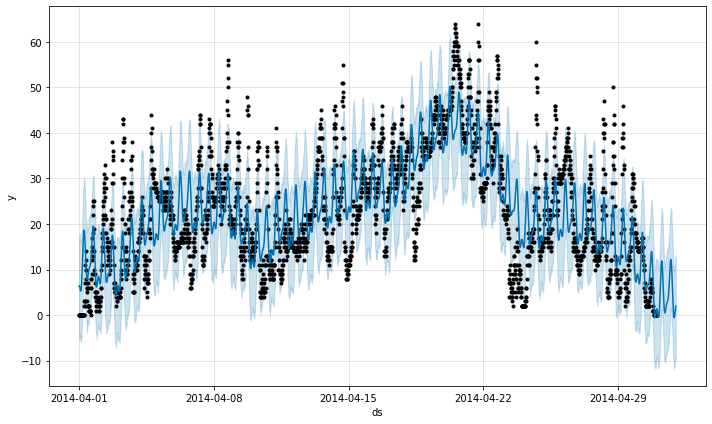

In [12]:
model.plot(forecast);

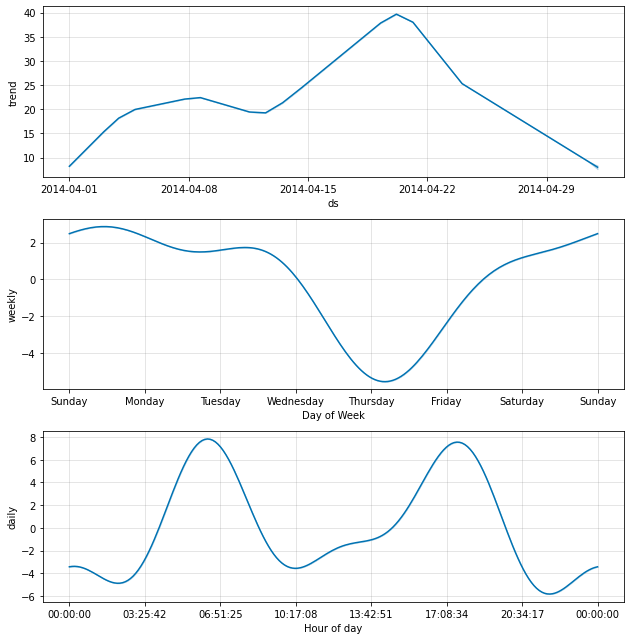

In [13]:
model.plot_components(forecast);

In [71]:
predictions = forecast['yhat'].tail(96).values
clean_predictions = []
for prediction in predictions:
    clean_predictions.append(round(prediction))

clean_predictions[70]

12

In [40]:
from geopy.geocoders import Nominatim
import geopy.distance

geolocator = Nominatim(user_agent="my_app")

start = geolocator.geocode("One World Trade Center New York")
end = geolocator.geocode("Empire State Building")

start_point = (start.latitude, start.longitude)
end_point = (end.latitude, end.longitude)

stations_coordinates = cleaning.stations_coordinates(april)
stations_coordinates = cleaning.geo_points_stations (stations_coordinates)

distance_to_start = []
for i, row in stations_coordinates.iterrows():
    distance_to_start.append(geopy.distance.distance(start_point, row['coordinates']).m)
stations_coordinates['distance_to_start'] = distance_to_start

distance_to_end = []
for i, row in stations_coordinates.iterrows():
    distance_to_end.append(geopy.distance.distance(end_point, row['coordinates']).m)
stations_coordinates['distance_to_end'] = distance_to_end

start_5 = stations_coordinates[['station_name', 'station_id', 'coordinates', 'distance_to_start']].sort_values(by=['distance_to_start'], ascending=True).iloc[:5]
end_5 = stations_coordinates[['station_name', 'station_id', 'coordinates', 'distance_to_end']].sort_values(by=['distance_to_end'], ascending=True).iloc[:5]

In [41]:
start_5

,station_name,station_id,coordinates,distance_to_start
221,Murray St & West St,309.0,"(40.7149787, -74.013012)",218.399427
36,Barclay St & Church St,417.0,"(40.71291224, -74.01020234)",251.695813
245,South End Ave & Liberty St,3002.0,"(40.711512, -74.015756)",274.508755
177,Greenwich St & Warren St,147.0,"(40.71542197, -74.01121978)",314.256769
228,Park Pl & Church St,319.0,"(40.71336124, -74.00937622)",323.516029


In [66]:
# for id in start_5.station_id.to_list():

test_0 = start_5.station_id.to_list()[0]


In [ ]:


tab1.markdown(f'5 closest stations from **{from_where}**:')

tab1.dataframe(start_5)



# Map with plotted station points:
figure15 = Figure(width=850,height=550)
new_york15 = folium.Map(location=[40.7230679, -73.974965513],zoom_start=13)

folium.TileLayer('cartodbpositron').add_to(new_york15)
figure15.add_child(new_york15)


for i, row in start_5.iterrows():

    marker = {'location': row['Coordinates'], 'tooltip': 'Citi Bike Station'}

    icon = folium.Icon(color='lightblue', icon='')

    new_marker = folium.Marker(**marker, icon = icon, radius = 2)

    new_marker.add_to(new_york15)

for i, row in end_5.iterrows():

    marker = {'location': row['Coordinates'], 'tooltip': 'Citi Bike Station'}

    icon = folium.Icon(color='darkblue', icon='')

    new_marker = folium.Marker(**marker, icon = icon, radius = 2)

    new_marker.add_to(new_york15)
with tab1:
    st_folium(figure15, width = 850)

tab1.markdown(f'5 closest stations from **{to_where}**:')

tab1.dataframe(end_5)